<a href="https://colab.research.google.com/github/Munazza-Farees/NITW-SIP2025-Project/blob/main/LDoS_LNN_Model_Preprocessed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
# !pip install imbalanced-learn pandas numpy scikit-learn --quiet

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Final_data.csv')
print("Shape: ", data.shape)

Shape:  (1048575, 28)


In [4]:
# Drop non-numeric and redundant features
drop_cols = ['Time', 'Source', 'Destination', 'Protocol']
data.drop(columns=drop_cols, inplace=True, errors='ignore')

# Encode label
data['Label'] = data['Label'].map({'normal': 0, 'attack': 1})
print("Class distribution:\n", data['Label'].value_counts())

Class distribution:
 Label
0    735972
1    312603
Name: count, dtype: int64


In [5]:
# Separate features and label
X = data.drop('Label', axis=1)
y = data['Label']

# Normalize using RobustScaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Normalized Sample:\n",X_scaled.head())

Normalized Sample:
      Length  src_port   dst_port  Flow_Duration  Total_Packets  Total_Bytes  \
0  0.013717  1.281885   0.987954      -0.978872      -1.136550    -0.523245   
1  0.000000  0.113126  11.194941      -0.978872      -1.136550    -0.523245   
2  1.000000  1.386345   0.987954      -0.881352      -0.947024     0.000000   
3  1.000000  1.386345   0.987954      -0.881352      -0.947024     0.000000   
4  1.000000  1.386345   0.987954      -0.881352      -0.947024     0.000000   

   Mean_Packet_Size  Packet_Rate  Byte_Rate  Packet_Size_Entropy  ...  \
0         -0.319964          NaN        NaN                  0.0  ...   
1         -0.333681          NaN        NaN                  0.0  ...   
2          0.666319     0.811925   0.807555                  0.0  ...   
3          0.666319     0.811925   0.807555                  0.0  ...   
4          0.666319     0.811925   0.807555                  0.0  ...   

   Average_Bytes_Per_Flow  Flow_Count_Per_Source  Packet_Loss_Rate

In [6]:
print("Imputing missing values...")
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

def adays_sampling(X, y, entropy_cols=['Packet_Size_Entropy', 'Inter_Arrival_Time_Entropy']):
    print("Applying SMOTE oversampling...")
    smote = SMOTE()
    X_smote, y_smote = smote.fit_resample(X_imputed, y)

    print("Calculating entropy weights...")
    X_smote_df = pd.DataFrame(X_smote, columns=X.columns)
    entropy_score = X_smote_df[entropy_cols].mean(axis=1)
    weights = entropy_score / entropy_score.max()

    print("Blending original and synthetic samples (ADAYS)...")
    X_adays = X_smote_df.copy()
    original_means = pd.DataFrame(X_imputed, columns=X.columns).mean()

    for col in tqdm(X.columns, desc="Blending features", ncols=80):
        X_adays[col] = original_means[col] * (1 - weights) + X_adays[col] * weights

    print("ADAYS sampling completed.")
    return X_adays, y_smote

X_balanced, y_balanced = adays_sampling(X_scaled, y)
print("Balanced Class Distribution:\n", pd.Series(y_balanced).value_counts())

Imputing missing values...
Applying SMOTE oversampling...
Calculating entropy weights...
Blending original and synthetic samples (ADAYS)...


Blending features: 100%|████████████████████████| 23/23 [00:00<00:00, 40.35it/s]

ADAYS sampling completed.
Balanced Class Distribution:
 Label
0    735972
1    735972
Name: count, dtype: int64


In [7]:
# Combine and save
df_preprocessed = X_balanced.copy()
df_preprocessed['Label'] = y_balanced
df_preprocessed.to_csv("ldos_preprocessed.csv", index=False)
print("✅ Preprocessed data saved as 'ldos_preprocessed.csv'")
files.download("ldos_preprocessed.csv")

✅ Preprocessed data saved as 'ldos_preprocessed.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-8-1260976067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


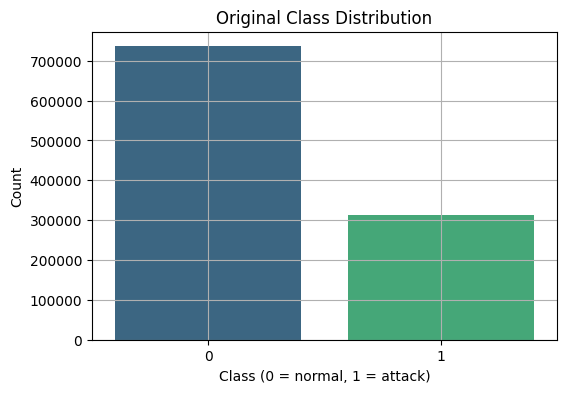

In [8]:
# Original class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette='viridis')
plt.title("Original Class Distribution")
plt.xlabel("Class (0 = normal, 1 = attack)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

/tmp/ipython-input-9-3002433162.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced, palette='coolwarm')


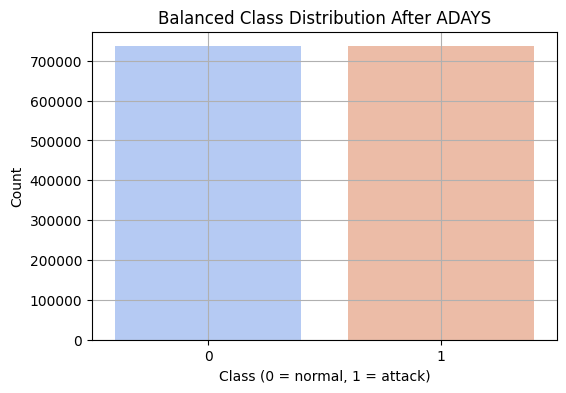

In [9]:
# Balanced class distribution after ADAYS
plt.figure(figsize=(6,4))
sns.countplot(x=y_balanced, palette='coolwarm')
plt.title("Balanced Class Distribution After ADAYS")
plt.xlabel("Class (0 = normal, 1 = attack)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

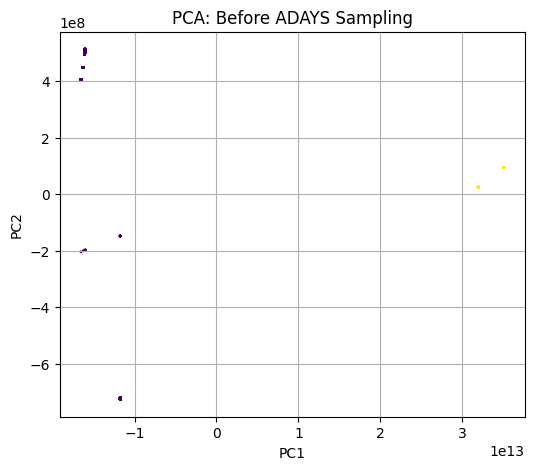

In [11]:
# Visualize before sampling
pca_before = PCA(n_components=2)
X_pca_before = pca_before.fit_transform(X_imputed)
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_before[:, 0], X_pca_before[:, 1], c=y, cmap='viridis', s=1)
plt.title("PCA: Before ADAYS Sampling")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()

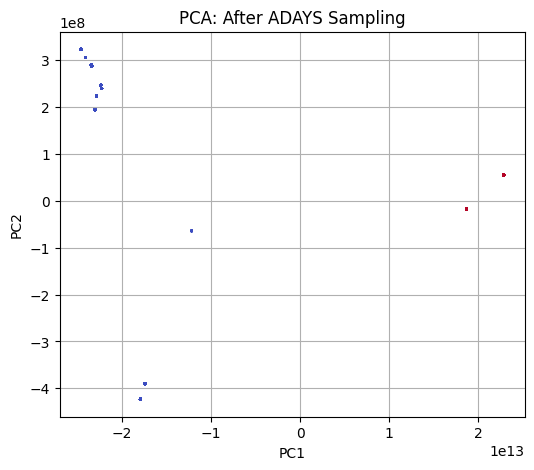

In [12]:
# Visualize after sampling
pca_after = PCA(n_components=2)
X_pca_after = pca_after.fit_transform(X_balanced)
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_after[:, 0], X_pca_after[:, 1], c=y_balanced, cmap='coolwarm', s=1)
plt.title("PCA: After ADAYS Sampling")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()